**Predicting Diabetes with PSpark**
EDA

In [366]:
pip install pyspark py4j

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [390]:
from pyspark.sql import SparkSession

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

from pyspark.sql import functions as F
from pyspark.sql.functions import rank, sum, desc
from pyspark.sql import Window

from pyspark.mllib.stat import Statistics
import pandas as pd


In [368]:
spark = SparkSession.builder.appName("Stress based Sleep Quality").getOrCreate()

In [369]:
df = spark.read.csv("SaYoPillow.csv", header=True, inferSchema=True)

In [370]:
df.show(2)

+-----------+---------------+-----------+------------+--------+-----------+-------------+---------+-----------+
|SnoringRate|RespirationRate|Temperature|LimbMovement|BloodOxy|EyeMovement|SleepingHours|HeartRate|StressLevel|
+-----------+---------------+-----------+------------+--------+-----------+-------------+---------+-----------+
|       93.8|          25.68|      91.84|        16.6|   89.84|       99.6|         1.84|     74.2|          3|
|      91.64|         25.104|     91.552|       15.88|  89.552|      98.88|        1.552|    72.76|          3|
+-----------+---------------+-----------+------------+--------+-----------+-------------+---------+-----------+
only showing top 2 rows



In [371]:
df.printSchema()

root
 |-- SnoringRate: double (nullable = true)
 |-- RespirationRate: double (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- LimbMovement: double (nullable = true)
 |-- BloodOxy: double (nullable = true)
 |-- EyeMovement: double (nullable = true)
 |-- SleepingHours: double (nullable = true)
 |-- HeartRate: double (nullable = true)
 |-- StressLevel: integer (nullable = true)



In [372]:
df.describe().toPandas()

summary         SnoringRate    RespirationRate         Temperature  \
0   count                 630                630                 630   
1    mean                71.6  21.80000000000002   92.80000000000004   
2  stddev  19.372832993333724  3.966110812389465  3.5296896551967802   
3     min                45.0               16.0                85.0   
4     max               100.0               30.0                99.0   

        LimbMovement           BloodOxy         EyeMovement  \
0                630                630                 630   
1  11.70000000000001               90.9   88.49999999999996   
2  4.299629148055771  3.902483005587985  11.893746603450513   
3                4.0               82.0                60.0   
4               19.0               97.0               105.0   

        SleepingHours          HeartRate         StressLevel  
0                 630                630                 630  
1  3.7000000000000006   64.5000000000001                 2.0  
2   3.054572011735975  9.915277030973662  1.4153372920397718  
3                 0.0               50.0                   0  
4                 9.0               85.0                   4

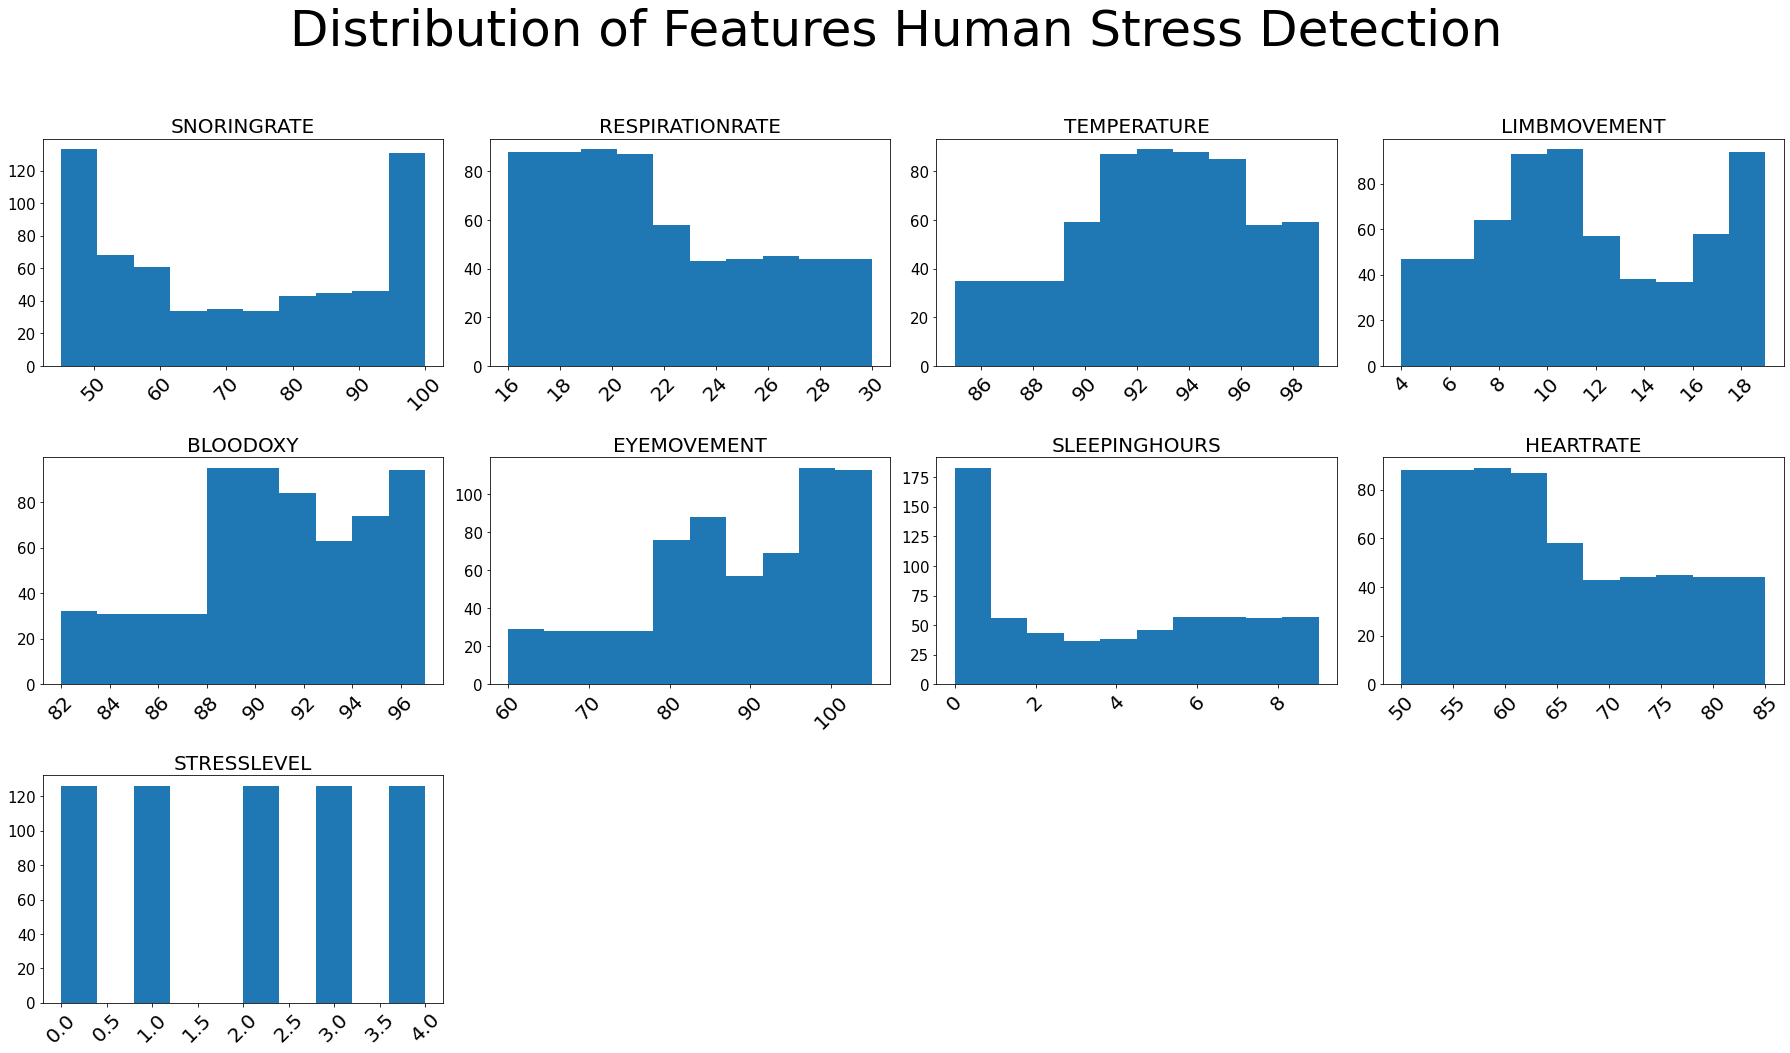

In [373]:
fig = plt.figure(figsize=(25,15))
st = fig.suptitle("Distribution of Features Human Stress Detection", fontsize=50, verticalalignment="center")
for col, num in zip(df.toPandas().describe().columns, range(1,11)):
  ax=fig.add_subplot(3,4,num)
  ax.hist(df.toPandas()[col])
  plt.grid(False)
  plt.xticks(rotation=45, fontsize=20)
  plt.yticks(fontsize=15)
  plt.title(col.upper(), fontsize=20)


plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85, hspace=0.4)
plt.show()

In [374]:
df.select([count(when(isnan(c),c)).alias(c) for c in df.columns]).toPandas().head()

SnoringRate  RespirationRate  Temperature  LimbMovement  BloodOxy  \
0            0                0            0             0         0   

   EyeMovement  SleepingHours  HeartRate  StressLevel  
0            0              0          0            0

###User Defined Functions (UDF)


In [392]:
df.groupby('HeartRate').count().show()

+---------+-----+
|HeartRate|count|
+---------+-----+
|     56.8|    1|
|     64.2|    1|
|     69.8|    1|
|    53.08|    1|
|    58.92|    1|
|    70.52|    1|
|    51.68|    1|
|     55.8|    1|
|     67.0|    1|
|    75.96|    1|
|     54.2|    1|
|    79.24|    1|
|     69.0|    1|
|    79.08|    1|
|    55.44|    1|
|    69.72|    1|
|    84.92|    1|
|    66.44|    1|
|    83.56|    1|
|    57.32|    1|
+---------+-----+
only showing top 20 rows



In [393]:
def udf_multi(HeartRate):
  if (HeartRate >=50 and HeartRate <=60):
    return "HR 50-60"
  elif (HeartRate >60 and HeartRate <=70):
    return "HR 61-70"
  elif (HeartRate >70 and HeartRate <=80):
    return "HR 71-80"
  elif (HeartRate >80 and HeartRate <=90):
    return "HR 81-90"

  else: return "NA"

In [394]:
HR_udf = udf(udf_multi)
df=df.withColumn ('HR_udf', HR_udf('HeartRate'))

In [431]:
df.show()

+-----------+---------------+-----------+------------+--------+-----------+-------------+---------+-----------+--------+------------------+
|SnoringRate|RespirationRate|Temperature|LimbMovement|BloodOxy|EyeMovement|SleepingHours|HeartRate|StressLevel|  HR_udf|            SL_udf|
+-----------+---------------+-----------+------------+--------+-----------+-------------+---------+-----------+--------+------------------+
|       93.8|          25.68|      91.84|        16.6|   89.84|       99.6|         1.84|     74.2|          3|HR 71-80|Stress Medium High|
|      91.64|         25.104|     91.552|       15.88|  89.552|      98.88|        1.552|    72.76|          3|HR 71-80|Stress Medium High|
|       60.0|           20.0|       96.0|        10.0|    95.0|       85.0|          7.0|     60.0|          1|HR 50-60| Stress Low Medium|
|      85.76|         23.536|     90.768|       13.92|  88.768|      96.92|        0.768|    68.84|          3|HR 61-70|Stress Medium High|
|      48.12|       

In [381]:
window = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

In [398]:
HR_group_Temperature = df.select(["HR_udf","Temperature"]).\
                    groupBy('HR_udf').\
                        agg(
                            F.count('Temperature').alias('UserCount'),
                            F.mean('Temperature').alias('Temperature_AVG'),
                            F.min('Temperature').alias('Temperature_MIN'),
                            F.max('Temperature').alias('Temperature_MAX')).\
                        withColumn('total', sum(col('UserCount')).over(window)).\
                        withColumn('Percent', col('UserCount')*100/col('total')).\
                        drop(col('total')).sort(desc('Percent'))

In [399]:
HR_group_Temperature.toPandas()

HR_udf  UserCount  Temperature_AVG  Temperature_MIN  Temperature_MAX  \
0  HR 50-60        253        96.233202            92.00             99.0   
1  HR 61-70        188        92.166213            90.00             94.0   
2  HR 71-80        126        88.872000            85.00             92.0   
3  HR 81-90         63        88.760000            87.52             90.0   

    Percent  
0  40.15873  
1  29.84127  
2  20.00000  
3  10.00000

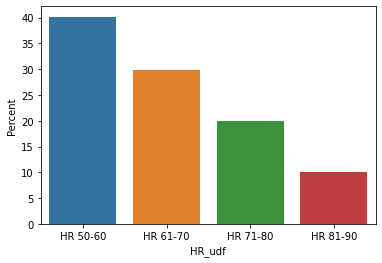

In [402]:
sns.barplot(x="HR_udf", y="Percent", data=HR_group_Temperature.toPandas())

In [403]:
HR_group_Sleeping = df.select(["HR_udf","SleepingHours"]).\
                    groupBy('HR_udf').\
                        agg(
                            F.count('SleepingHours').alias('UserCount'),
                            F.mean('SleepingHours').alias('SleepingHours_AVG'),
                            F.min('SleepingHours').alias('SleepingHours_MIN'),
                            F.max('SleepingHours').alias('SleepingHours_MAX')).\
                        withColumn('total', sum(col('UserCount')).over(window)).\
                        withColumn('Percent', col('UserCount')*100/col('total')).\
                        drop(col('total')).sort(desc('Percent'))

In [404]:
HR_group_Sleeping.toPandas()

HR_udf  UserCount  SleepingHours_AVG  SleepingHours_MIN  \
0  HR 50-60        253           6.980237                2.0   
1  HR 61-70        188           2.501319                0.0   
2  HR 71-80        126           0.752000                0.0   
3  HR 81-90         63           0.000000                0.0   

   SleepingHours_MAX   Percent  
0                9.0  40.15873  
1                5.0  29.84127  
2                2.0  20.00000  
3                0.0  10.00000

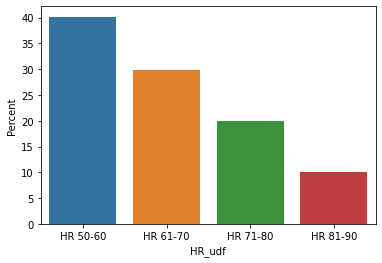

In [407]:
sns.barplot(x="HR_udf", y="Percent", data=HR_group_Sleeping.toPandas())

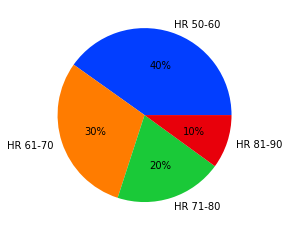

In [409]:
# user count
plt.figure()
values = [253, 188, 126, 63] 
labels = ['HR 50-60', 'HR 61-70', 'HR 71-80', 'HR 81-90'] 
colors = sns.color_palette('bright')[0:5]
plt.pie(values, labels=labels, colors=colors,  autopct='%.0f%%') 
plt.show()

In [410]:
df.groupby('StressLevel').count().show()

+-----------+-----+
|StressLevel|count|
+-----------+-----+
|          1|  126|
|          3|  126|
|          4|  126|
|          2|  126|
|          0|  126|
+-----------+-----+



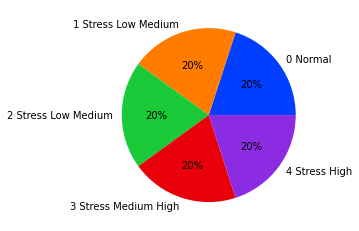

In [411]:
# user count
plt.figure()
values = [126, 126, 126, 126, 126] 
labels = ['0 Normal', '1 Stress Low Medium', '2 Stress Low Medium', '3 Stress Medium High', '4 Stress High'] 
colors = sns.color_palette('bright')[0:5]
plt.pie(values, labels=labels, colors=colors,  autopct='%.0f%%') 
plt.show()

##Correlation

In [412]:
numeric_features=[t[0] for t in df.dtypes if t[1] !='string']
numeric_features_df = df.select(numeric_features)
numeric_features_df.toPandas().head()

SnoringRate  RespirationRate  Temperature  LimbMovement  BloodOxy  \
0        93.80           25.680       91.840        16.600    89.840   
1        91.64           25.104       91.552        15.880    89.552   
2        60.00           20.000       96.000        10.000    95.000   
3        85.76           23.536       90.768        13.920    88.768   
4        48.12           17.248       97.872         6.496    96.248   

   EyeMovement  SleepingHours  HeartRate  StressLevel  
0        99.60          1.840      74.20            3  
1        98.88          1.552      72.76            3  
2        85.00          7.000      60.00            1  
3        96.92          0.768      68.84            3  
4        72.48          8.248      53.12            0

In [413]:
col_names = numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])

In [414]:
corr_mat = Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index = col_names
corr_df.columns = col_names
round(corr_df, 2)

SnoringRate  RespirationRate  Temperature  LimbMovement  \
SnoringRate             1.00             0.98        -0.90          0.98   
RespirationRate         0.98             1.00        -0.89          0.99   
Temperature            -0.90            -0.89         1.00         -0.90   
LimbMovement            0.98             0.99        -0.90          1.00   
BloodOxy               -0.90            -0.89         1.00         -0.90   
EyeMovement             0.95             0.94        -0.86          0.96   
SleepingHours          -0.92            -0.89         0.95         -0.90   
HeartRate               0.98             1.00        -0.89          0.99   
StressLevel             0.98             0.96        -0.96          0.97   

                 BloodOxy  EyeMovement  SleepingHours  HeartRate  StressLevel  
SnoringRate         -0.90         0.95          -0.92       0.98         0.98  
RespirationRate     -0.89         0.94          -0.89       1.00         0.96  
Temperature          1.00        -0.86           0.95      -0.89        -0.96  
LimbMovement        -0.90         0.96          -0.90       0.99         0.97  
BloodOxy             1.00        -0.86           0.95      -0.89        -0.96  
EyeMovement         -0.86         1.00          -0.89       0.94         0.95  
SleepingHours        0.95        -0.89           1.00      -0.89        -0.97  
HeartRate           -0.89         0.94          -0.89       1.00         0.96  
StressLevel         -0.96         0.95          -0.97       0.96         1.00

In [415]:
df.columns

['SnoringRate',
 'RespirationRate',
 'Temperature',
 'LimbMovement',
 'BloodOxy',
 'EyeMovement',
 'SleepingHours',
 'HeartRate',
 'StressLevel',
 'HR_udf',
 'SL_udf']

In [416]:
numeric_features_df.columns

['SnoringRate',
 'RespirationRate',
 'Temperature',
 'LimbMovement',
 'BloodOxy',
 'EyeMovement',
 'SleepingHours',
 'HeartRate',
 'StressLevel']

In [417]:
df.groupby('StressLevel').count().show()

+-----------+-----+
|StressLevel|count|
+-----------+-----+
|          1|  126|
|          3|  126|
|          4|  126|
|          2|  126|
|          0|  126|
+-----------+-----+



In [418]:
col_names = numeric_features_df.columns
matriks_korelasi = list()
for i in col_names:
  for j in col_names:
    print(i, j, '=>', numeric_features_df.stat.corr(i, j))

SnoringRate SnoringRate => 1.0
SnoringRate RespirationRate => 0.9762676538361045
SnoringRate Temperature => -0.9024745269448675
SnoringRate LimbMovement => 0.9810777217319862
SnoringRate BloodOxy => -0.903139815690879
SnoringRate EyeMovement => 0.9505998574163778
SnoringRate SleepingHours => -0.9205544679253996
SnoringRate HeartRate => 0.9762676538361069
SnoringRate StressLevel => 0.9753221356542283
RespirationRate SnoringRate => 0.9762676538361045
RespirationRate RespirationRate => 1.0
RespirationRate Temperature => -0.8892374350470158
RespirationRate LimbMovement => 0.9917377417863347
RespirationRate BloodOxy => -0.8892103028892834
RespirationRate EyeMovement => 0.9355718699630327
RespirationRate SleepingHours => -0.8918548091540974
RespirationRate HeartRate => 1.0000000000000007
RespirationRate StressLevel => 0.9635158646021523
Temperature SnoringRate => -0.9024745269448675
Temperature RespirationRate => -0.8892374350470161
Temperature Temperature => 1.0
Temperature LimbMovement => 

In [ ]:
# Menentukan fitur apa saja yang ingin digunakan dari dataset untuk membangun model

In [432]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['SnoringRate','RespirationRate','Temperature','LimbMovement','BloodOxy','EyeMovement','SleepingHours','HeartRate'], 
                            outputCol="features")
output = assembler.transform(df)
model_df = output.select(['features', 'StressLevel'])
model_df = model_df.withColumnRenamed("StressLevel", "label")

print("Fitur untuk membangun model PySpark Decision tree dan Logistic Regression: ")
model_df.show()

Fitur untuk membangun model PySpark Decision tree dan Logistic Regression: 
+--------------------+-----+
|            features|label|
+--------------------+-----+
|[93.8,25.68,91.84...|    3|
|[91.64,25.104,91....|    3|
|[60.0,20.0,96.0,1...|    1|
|[85.76,23.536,90....|    3|
|[48.12,17.248,97....|    0|
|[56.88,19.376,95....|    1|
|[47.0,16.8,97.2,5...|    0|
|[50.0,18.0,99.0,8...|    0|
|[45.28,16.112,96....|    0|
|[55.52,19.104,95....|    1|
|[73.44,21.344,93....|    2|
|[59.28,19.856,95....|    1|
|[48.6,17.44,98.16...|    0|
|[96.288,26.288,85...|    4|
|[87.8,24.08,91.04...|    3|
|[52.32,18.464,94....|    1|
|[52.64,18.528,94....|    1|
|[86.24,23.664,90....|    3|
|[81.56,22.416,90....|    3|
|[63.68,20.368,92....|    2|
+--------------------+-----+
only showing top 20 rows



In [421]:
train, test = model_df.randomSplit([0.80, 0.20], seed=42)
print(f"Training Data Size: {train.count()}")
print(f"Test Data Size: {test.count()}")

Training Data Size: 530
Test Data Size: 100


Training Model

In [422]:
from pyspark.ml.classification import LogisticRegression

In [423]:
lr = LogisticRegression(featuresCol='features',labelCol='label', maxIter=5)
model = lr.fit(train)
pred = model.transform(test)
pred.select('label','features', 'rawPrediction','prediction','probability').toPandas().head()

label                                           features  \
0      0  [45.08, 16.032, 96.048, 4.064, 95.032, 60.32, ...   
1      0  [45.24, 16.096, 96.144, 4.192, 95.096, 60.96, ...   
2      0  [45.32, 16.128, 96.192, 4.256, 95.128, 61.28, ...   
3      0  [45.52, 16.208, 96.312, 4.416, 95.208, 62.08, ...   
4      0  [45.76, 16.304, 96.456, 4.608, 95.304, 63.04, ...   

                                       rawPrediction  prediction  \
0  [12.375914633709584, 6.7490904901548046, 2.660...         0.0   
1  [12.281314531155111, 6.752449428769898, 2.6617...         0.0   
2  [12.234014479877864, 6.754128898077438, 2.6621...         0.0   
3  [12.115764351684781, 6.7583275713463085, 2.663...         0.0   
4  [11.973864197853068, 6.763365979268952, 2.6643...         0.0   

                                         probability  
0  [0.9963529849211051, 0.0035868610251849394, 6....  
1  [0.9959793207879605, 0.003954528558495415, 6.6...  
2  [0.9957784278187632, 0.004152203632122589, 6.9...  
3  [0.9952313919357921, 0.004690496706843017, 7.8...  
4  [0.9944811134582789, 0.0054288259143820475, 9....

Evaluasi Model

In [424]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [425]:
eval = MulticlassClassificationEvaluator()
print(f"Test Area Under ROC: {eval.evaluate(pred)}")

Test Area Under ROC: 0.9583333333333333


Akurasi Model

In [426]:
acc = pred.filter(pred.label == pred.prediction).count() / float(pred.count())
print(f"Accuracy: {acc}")

Accuracy: 0.96


In [427]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [428]:
tree=DecisionTreeClassifier(featuresCol='features', labelCol ='label')
treemodel=tree.fit(train)
treemodelpredict=treemodel.transform(test)
treemodelpredict.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[45.08,16.032,96....|    0|[99.0,0.0,0.0,0.0...|[1.0,0.0,0.0,0.0,...|       0.0|
|[45.24,16.096,96....|    0|[99.0,0.0,0.0,0.0...|[1.0,0.0,0.0,0.0,...|       0.0|
|[45.32,16.128,96....|    0|[99.0,0.0,0.0,0.0...|[1.0,0.0,0.0,0.0,...|       0.0|
|[45.52,16.208,96....|    0|[99.0,0.0,0.0,0.0...|[1.0,0.0,0.0,0.0,...|       0.0|
|[45.76,16.304,96....|    0|[99.0,0.0,0.0,0.0...|[1.0,0.0,0.0,0.0,...|       0.0|
|[45.92,16.368,96....|    0|[99.0,0.0,0.0,0.0...|[1.0,0.0,0.0,0.0,...|       0.0|
|[46.16,16.464,96....|    0|[99.0,0.0,0.0,0.0...|[1.0,0.0,0.0,0.0,...|       0.0|
|[46.4,16.56,96.84...|    0|[99.0,0.0,0.0,0.0...|[1.0,0.0,0.0,0.0,...|       0.0|
|[46.8,16.72,97.08...|    0|[99.0,0.0,0.0,0.0...|[1.0,0.0,0.0,0.0,...|       0.0|
|[46.84,16.736,9

In [429]:
accuracy= MulticlassClassificationEvaluator(labelCol ='label',
                                            metricName ='accuracy')
accuracy.evaluate(treemodelpredict)

1.0

In [430]:
precision= MulticlassClassificationEvaluator(labelCol ='label',
                                            metricName ='weightedPrecision')
precision.evaluate(treemodelpredict)

1.0